In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#from datetime import date
import re

# 1. Exploration des données

In [3]:
# on commence par charger les labels
h1_labels = pd.read_table('data/house1_labels.txt', header=None, names=['label'], usecols=[0])
h1_labels['label'] = h1_labels['label'].str.extract(r'[0-9]+ (.*)')
h1_labels['label'] = h1_labels['label'].str.replace(re.compile(r'( \(.*\))'), '')

# on définit des groupes, sans les 'L1' / 'L2'
h1_labels['group'] = h1_labels['label'].str.extract(r'(.*) L[0-9]').apply(lambda x: x.fillna(h1_labels['label']))
h1_labels['id'] = (h1_labels.index + 1)

# on définit les id
h1_labels['id'] = h1_labels['id'].apply(lambda x: 'sub'+str(x))

# on définit les équipements qui conditionnent l'activité
lables_map = {'Kitchen Wall Oven': 1,
'Kitchen Counter Plugs': 1,
'Upstairs Bedroom AFCI Arc-Fault Plugs': 1,
'Clothes Dryer': 1,
'Upstairs Bedroom': 1,
'Kitchen Fridge': 0,
'Clothes Washer': 1,
'Kitchen Dishwasher': 1,
'Furnace & Hot Water Unit': 0,
'Basement Plugs & Lights': 1,
'Heat Pump': 0,
'Garage Sub-Panel': 1,
'Upstairs Plugs & Lights': 1,
'Basement Blue Plugs': 1,
'Bathrooms': 0,
'Rental Suite Sub-Panel': 0,
'Misc. Plugs': 1,
'Home Office': 1}

h1_labels['activity'] = h1_labels['group'].map(lables_map)

h1_labels

,label,group,id,activity
0,Kitchen Wall Oven L1,Kitchen Wall Oven,sub1,1
1,Kitchen Wall Oven L2,Kitchen Wall Oven,sub2,1
2,Kitchen Counter Plugs L1,Kitchen Counter Plugs,sub3,1
3,Kitchen Counter Plugs L2,Kitchen Counter Plugs,sub4,1
4,Clothes Dryer L1,Clothes Dryer,sub5,1
5,Clothes Dryer L2,Clothes Dryer,sub6,1
6,Upstairs Bedroom AFCI Arc-Fault Plugs,Upstairs Bedroom AFCI Arc-Fault Plugs,sub7,1
7,Kitchen Fridge,Kitchen Fridge,sub8,0
8,Clothes Washer,Clothes Washer,sub9,1
9,Kitchen Dishwasher,Kitchen Dishwasher,sub10,1


In [4]:
all_groups = h1_labels.loc[:, 'group'].unique()
labels_active = h1_labels.loc[h1_labels['activity'] > 0, 'group'].unique()
groups_subs13_24 = h1_labels.loc[12:, 'group'].unique()
groups_subs13_24

array(['Heat Pump', 'Garage Sub-Panel', 'Upstairs Plugs & Lights',
       'Basement Blue Plugs', 'Bathrooms', 'Rental Suite Sub-Panel',
       'Misc. Plugs', 'Home Office'], dtype=object)

In [32]:
def load_aggregate_dataset(filename, sub_panels='all', resample_period=None) -> pd.DataFrame:
    """
    Loads the disaggregated dataset, aggregates the targetted sub-panels and removes the other columns
    filename: the path to the file to load
    sub_panels: (optional) the sub-panels to aggregate can be a list of strings containing the names of the sub-panels, or 'all' to select all panels or 'active_house1', 'active_house2', 'inactive_house1' or 'inactive_house2'
    resample_period: (optional) the reasmple period, if None the default period of 1 second will be used
    returns: a DataFrame containing the dataset
    """
    dataset = pd.read_csv(filename)
    dataset['datetime'] = pd.to_datetime(dataset['unix_ts'], unit='s')
    dataset['datetime'] = dataset['datetime'] - pd.Timedelta("8 hours")

    dataset = dataset.set_index(dataset['datetime'])
    # we drop unnecessary columns
    dataset = dataset.drop(columns=['unix_ts', 'datetime', 'ihd', 'mains'])
    dataset = dataset.asfreq('s').interpolate('linear')

    if isinstance(sub_panels, str):
        if sub_panels == 'active_house1':
            sub_panels = ['sub1', 'sub2', 'sub3', 'sub4', 'sub5', 'sub6', 'sub7', 'sub9', 'sub10', 'sub12', 'sub15', 'sub16', 'sub17', 'sub18', 'sub19', 'sub21', 'sub22', 'sub23', 'sub24']
        elif sub_panels == 'inactive_house1':
            sub_panels = ['sub8', 'sub11', 'sub13', 'sub14', 'sub20']
        elif sub_panels == 'active_house2':
            sub_panels = ['sub1', 'sub2', 'sub3', 'sub4', 'sub5', 'sub6', 'sub7', 'sub9', 'sub10', 'sub12', 'sub14', 'sub15', 'sub16', 'sub17', 'sub18', 'sub19', 'sub20', 'sub21']
        elif sub_panels == 'inactive_house2':
            sub_panels = ['sub8', 'sub11', 'sub13']
        elif sub_panels == 'all':
            sub_panels = dataset.columns
        else:
            raise Exception(f"Wrong value for argument sub_panels. Expected 'all', 'active_house1/2', 'inactive_house1/2' or list, got {sub_panels}")
    
    dataset['mains'] = dataset[sub_panels].sum(axis=1)
    
    dataset = dataset.drop(columns=dataset.columns[:-1])

    if resample_period:
        dataset = dataset.resample(resample_period).nearest()
    

    return dataset

house1_power_blk1 = load_aggregate_dataset('data/house1_power_blk1.zip')


house1_power_blk1.head()

,mains
datetime,
2016-02-07 00:00:00,646
2016-02-07 00:00:01,636
2016-02-07 00:00:02,640
2016-02-07 00:00:03,640
2016-02-07 00:00:04,643


In [5]:
house1_power_blk1 = pd.read_csv('data/house1_power_blk1.csv')
house1_power_blk1['datetime'] = pd.to_datetime(house1_power_blk1['unix_ts'], unit='s')
#house1_power_blk1['datetime'] = house1_power_blk1['datetime'].dt.tz_localize('UTC').dt.tz_convert('America/Vancouver')
house1_power_blk1['datetime'] = house1_power_blk1['datetime'] - pd.Timedelta("8 hours")

house1_power_blk1 = house1_power_blk1.set_index(house1_power_blk1['datetime'])
house1_power_blk1 = house1_power_blk1.drop(columns=['unix_ts', 'datetime'])

# id_label = {id: label for label, id in h1_labels.values}
# house1_power_blk1 = house1_power_blk1.rename(columns=id_label)
for group in h1_labels['group'].unique():
    sub_id = h1_labels.loc[h1_labels['group'] == group, 'id'].values
    house1_power_blk1[group] = house1_power_blk1[sub_id].sum(axis=1)
    house1_power_blk1 = house1_power_blk1.drop(columns=sub_id)

house1_power_blk1.head()

,ihd,mains,Kitchen Wall Oven,Kitchen Counter Plugs,Clothes Dryer,Upstairs Bedroom AFCI Arc-Fault Plugs,Kitchen Fridge,Clothes Washer,Kitchen Dishwasher,Furnace & Hot Water Unit,Basement Plugs & Lights,Heat Pump,Garage Sub-Panel,Upstairs Plugs & Lights,Basement Blue Plugs,Bathrooms,Rental Suite Sub-Panel,Misc. Plugs,Home Office
datetime,,,,,,,,,,,,,,,,,,,
2016-02-07 00:00:00,NaN,646,1,2,0,5,0,0,0,139,112,38,1,9,20,113,45,0,161
2016-02-07 00:00:01,NaN,636,1,1,0,5,0,0,0,140,112,38,1,9,20,113,44,0,152
2016-02-07 00:00:02,NaN,640,1,2,0,5,0,0,0,139,112,38,1,9,21,113,45,0,154
2016-02-07 00:00:03,NaN,640,1,2,0,5,0,0,0,140,112,38,1,9,20,113,45,0,154
2016-02-07 00:00:04,NaN,643,1,2,0,7,0,0,0,141,112,38,1,9,21,113,45,0,153


In [5]:
house1_power_blk1.describe()

,ihd,mains,Kitchen Wall Oven,Kitchen Counter Plugs,Clothes Dryer,Upstairs Bedroom AFCI Arc-Fault Plugs,Kitchen Fridge,Clothes Washer,Kitchen Dishwasher,Furnace & Hot Water Unit,Basement Plugs & Lights,Heat Pump,Garage Sub-Panel,Upstairs Plugs & Lights,Basement Blue Plugs,Bathrooms,Rental Suite Sub-Panel,Misc. Plugs,Home Office
count,51781.000000,777600.000000,777600.000000,777600.000000,777600.000000,777600.000000,777600.000000,777600.000000,777600.000000,777600.000000,777600.000000,777600.000000,777600.000000,777600.000000,777600.000000,777600.000000,777600.000000,777600.000000,777600.000000
mean,1357.122188,1343.087585,0.992980,10.063137,45.238618,29.509416,48.878970,2.738471,17.542393,128.008237,119.710684,310.978437,0.999527,95.426109,27.037939,31.551321,302.637508,1.818210,169.955630
std,1019.259753,1018.853946,0.085336,116.419527,446.929881,30.941163,71.115971,29.595356,111.356479,51.924557,40.001579,648.016402,0.043031,149.196118,34.759162,60.570696,496.067432,8.079135,29.116743
min,386.000000,344.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,35.000000,51.000000,0.000000,0.000000,6.000000,10.000000,1.000000,41.000000,0.000000,121.000000
25%,697.000000,684.000000,1.000000,1.000000,0.000000,5.000000,0.000000,0.000000,0.000000,138.000000,101.000000,36.000000,1.000000,9.000000,20.000000,2.000000,47.000000,0.000000,154.000000
50%,941.000000,927.000000,1.000000,2.000000,0.000000,11.000000,0.000000,0.000000,0.000000,145.000000,112.000000,38.000000,1.000000,9.000000,20.000000,2.000000,175.000000,0.000000,156.000000
75%,1508.000000,1494.000000,1.000000,2.000000,0.000000,47.000000,126.000000,0.000000,0.000000,148.000000,112.000000,38.000000,1.000000,156.000000,20.000000,3.000000,307.000000,0.000000,165.000000
max,7933.000000,18115.000000,2.000000,1729.000000,5483.000000,179.000000,1712.000000,1076.000000,806.000000,685.000000,350.000000,13948.000000,2.000000,1447.000000,993.000000,1804.000000,4865.000000,74.000000,919.000000


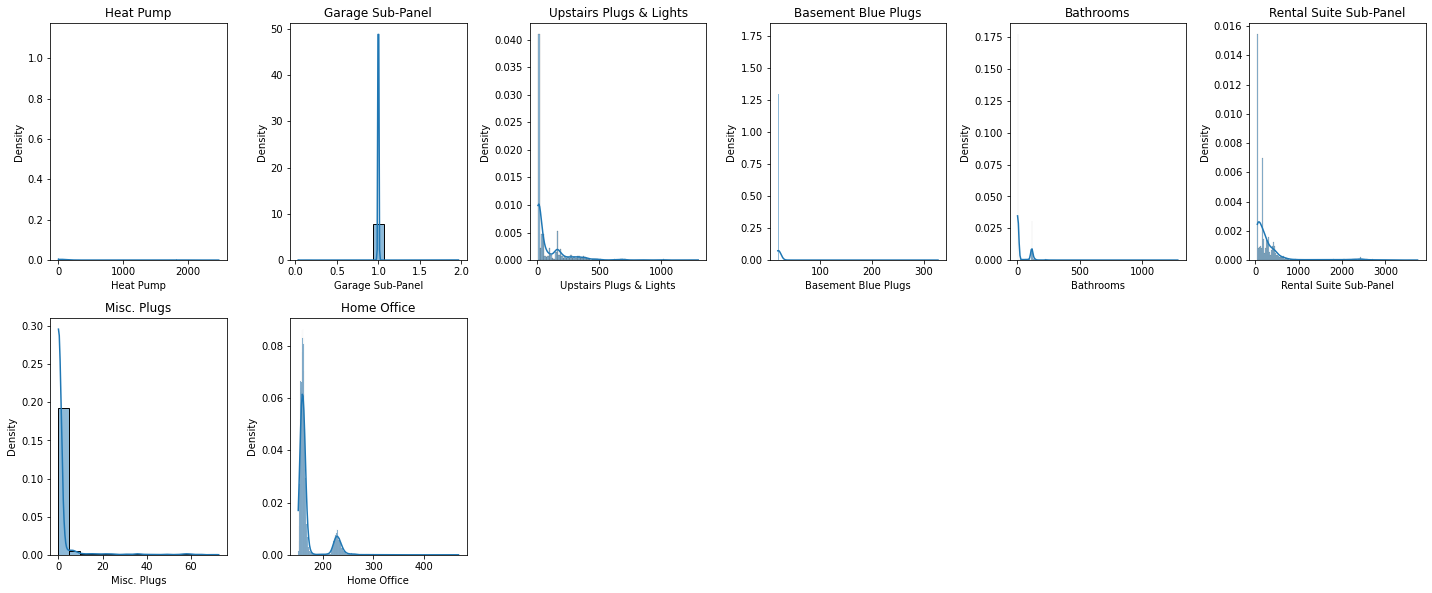

In [6]:
# we prepare our plot
fig = plt.figure(figsize=(20, 12));

house1_power_blk1_agg = house1_power_blk1.resample(rule='60s').mean()

# for each column
for k, col in enumerate(groups_subs13_24):
    # we add a subplot
    ax = fig.add_subplot(3, 6, k+1)

    # histogramme voltmean_5d et sa moyenne
    sns.histplot(data=house1_power_blk1_agg, x=col, kde=True, stat='density', ax=ax)
    #ax.vlines(x=house1_power_blk1_agg[col].mean(), ymin=0, ymax=ax.get_ylim()[-1], color='red', alpha=0.7, label='avg')
    ax.set_title(col)
    #ax.legend()

plt.tight_layout()
plt.show();

No handles with labels found to put in legend.


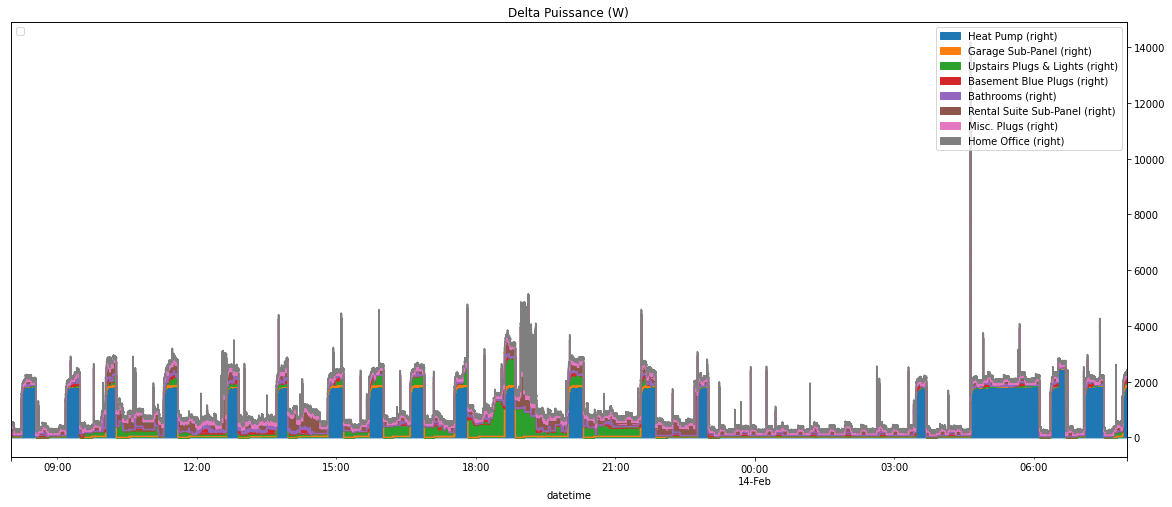

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))
#((((house1_power_blk1_norm[labels_active].abs() > tol).any(axis=1)*1).resample(rule='0.25H').mean() > 0.85)*1)['2016-02-13 08:00:00':'2016-02-14 08:00:00'].plot(label='activité 1', ax=ax);
#((((house1_power_blk1_diff.abs() > house1_power_blk1_diff.std())*1).resample(rule='1H').mean() > 0.01)*1).plot(label='activité 2', ax=ax);
axr = house1_power_blk1.loc['2016-02-13 08:00:00':'2016-02-14 08:00:00', groups_subs13_24].plot.area(title='Delta Puissance (W)',secondary_y=True, label='puissance', ax=ax);

ax.legend(loc='upper left');
axr.legend(loc='upper right');

# 2. Ajout des labels activité

Une autre approche pourrait être de considérer qu'il y a activité si certaines puissances sont supérieures à 0 (i.e. il y a bien une activité électrique sur ces équipements).

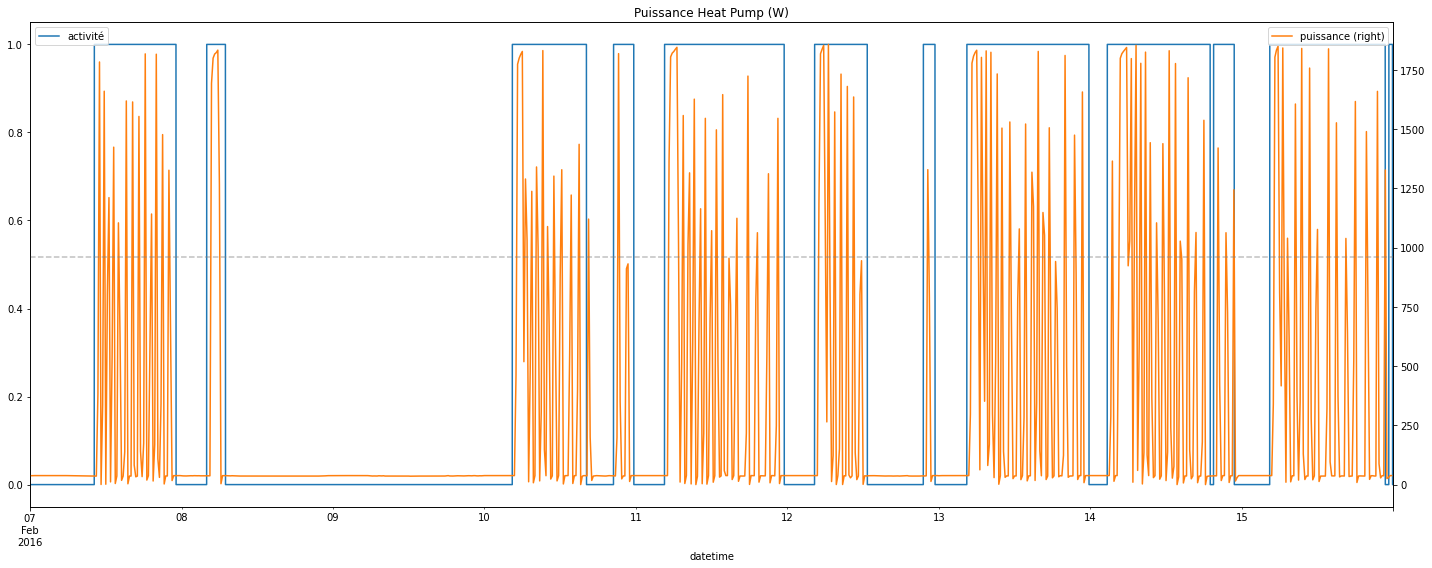

In [8]:
fig, ax = plt.subplots(1,1 , figsize=(20,8))

house1_power_blk1_resample = house1_power_blk1[groups_subs13_24].resample(rule='0.25H').mean().interpolate(method='linear')
tol = house1_power_blk1[groups_subs13_24].mean() + house1_power_blk1[groups_subs13_24].std()

col = groups_subs13_24[0]

((((house1_power_blk1[col] > tol[col])*1).rolling('2h', center=True).mean() > 0.11)*1).plot(label='activité', ax=ax);
axr = house1_power_blk1_resample[col].plot(title=f'Puissance {col} (W)',secondary_y=True, label='puissance', ax=ax);
axr.axhline(y=tol[col], linestyle='dashed', color='gray', alpha=0.5);

ax.legend(loc='upper left');
axr.legend(loc='upper right');

fig.tight_layout();

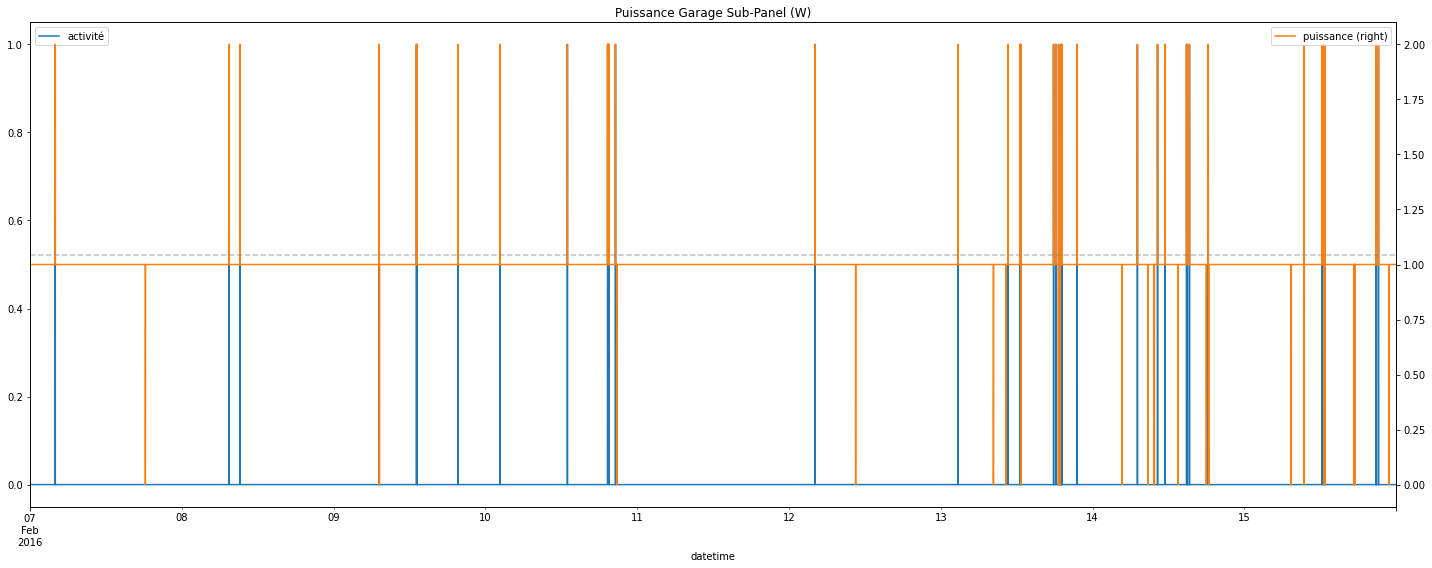

In [9]:
fig, ax = plt.subplots(1,1 , figsize=(20,8))

house1_power_blk1_resample = house1_power_blk1[groups_subs13_24] #.resample(rule='0.25H').mean().interpolate(method='linear')
tol = house1_power_blk1[groups_subs13_24].mean() + house1_power_blk1[groups_subs13_24].std()

col = groups_subs13_24[1]

((((house1_power_blk1[col] > tol[col])*1).rolling('15s', center=True).mean() > 0)*1).plot(label='activité', ax=ax);
axr = house1_power_blk1_resample[col].plot(title=f'Puissance {col} (W)',secondary_y=True, label='puissance', ax=ax);
axr.axhline(y=tol[col], linestyle='dashed', color='gray', alpha=0.5);

ax.legend(loc='upper left');
axr.legend(loc='upper right');

fig.tight_layout();

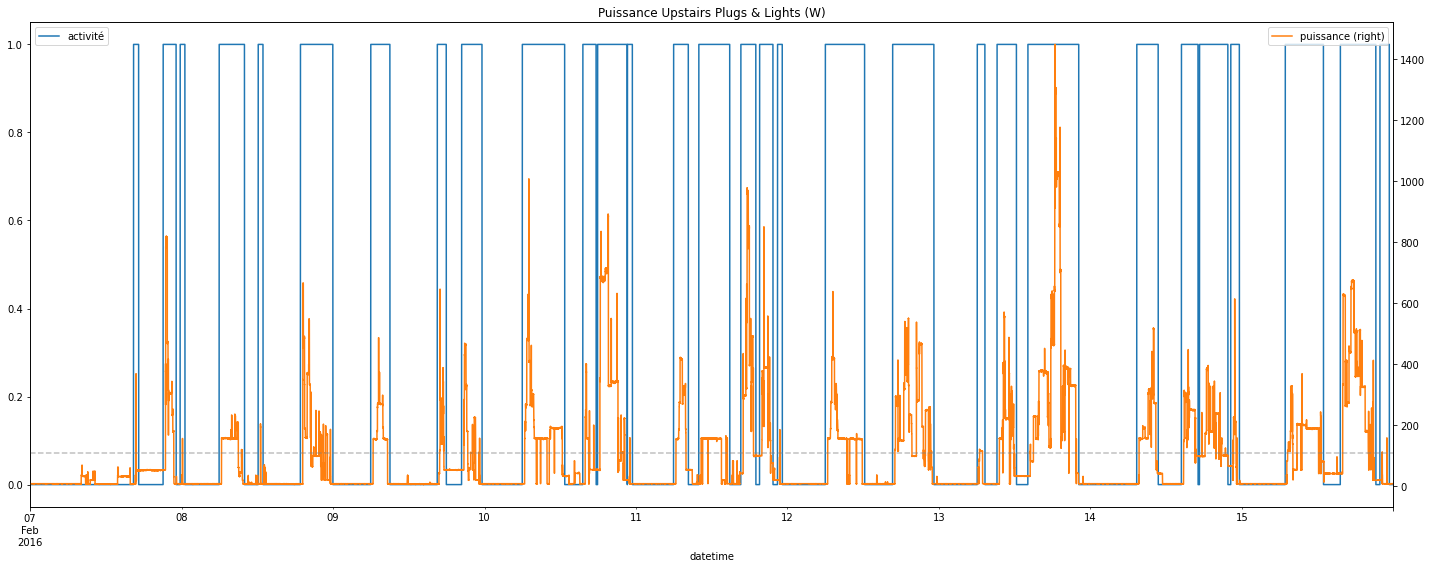

In [10]:
fig, ax = plt.subplots(1,1 , figsize=(20,8))

house1_power_blk1_resample = house1_power_blk1[groups_subs13_24] #.resample(rule='0.25H').mean().interpolate(method='linear')
tol = house1_power_blk1[groups_subs13_24].mean() + house1_power_blk1[groups_subs13_24].std() * 0.1

col = groups_subs13_24[2]

((((house1_power_blk1[col] > tol[col])*1).rolling('45min', center=True).mean() > 0)*1).plot(label='activité', ax=ax);
axr = house1_power_blk1_resample[col].plot(title=f'Puissance {col} (W)',secondary_y=True, label='puissance', ax=ax);
axr.axhline(y=tol[col], linestyle='dashed', color='gray', alpha=0.5);

ax.legend(loc='upper left');
axr.legend(loc='upper right');

fig.tight_layout();

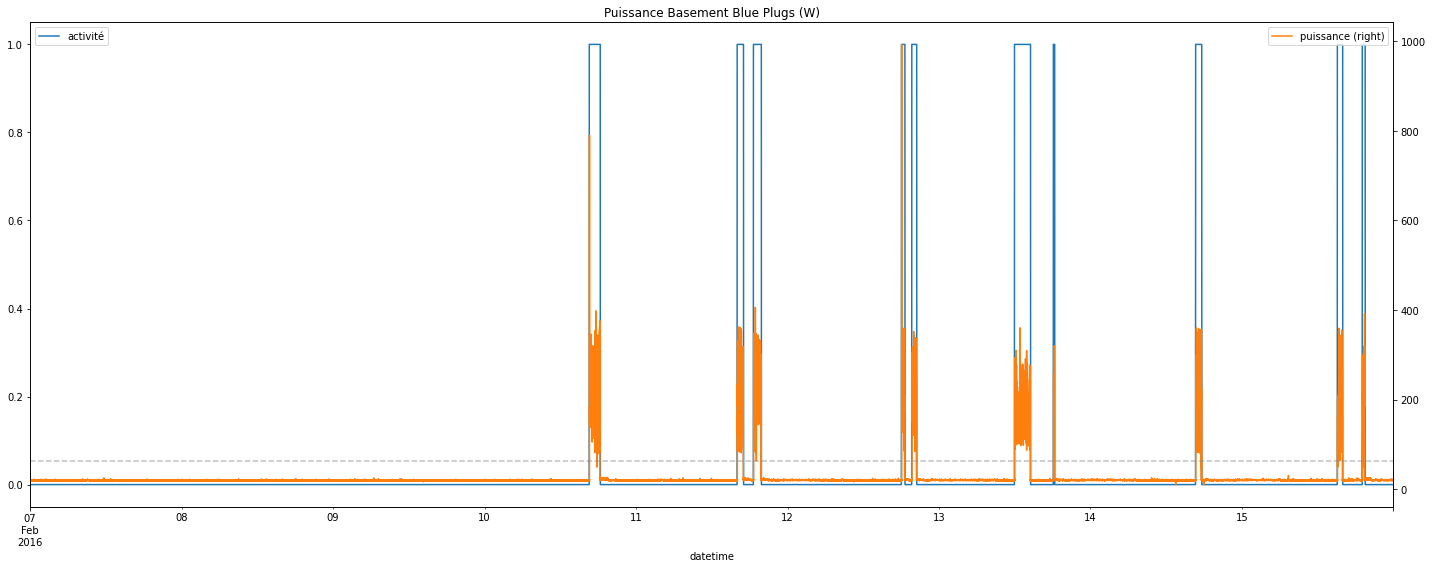

In [11]:
fig, ax = plt.subplots(1,1 , figsize=(20,8))

house1_power_blk1_resample = house1_power_blk1[groups_subs13_24] #.resample(rule='0.25H').mean().interpolate(method='linear')
tol = house1_power_blk1[groups_subs13_24].mean() + house1_power_blk1[groups_subs13_24].std()

col = groups_subs13_24[3]

((((house1_power_blk1[col] > tol[col])*1).rolling('10min', center=True).mean() > 0.2)*1).plot(label='activité', ax=ax);
axr = house1_power_blk1_resample[col].plot(title=f'Puissance {col} (W)',secondary_y=True, label='puissance', ax=ax);
axr.axhline(y=tol[col], linestyle='dashed', color='gray', alpha=0.5);

ax.legend(loc='upper left');
axr.legend(loc='upper right');

fig.tight_layout();

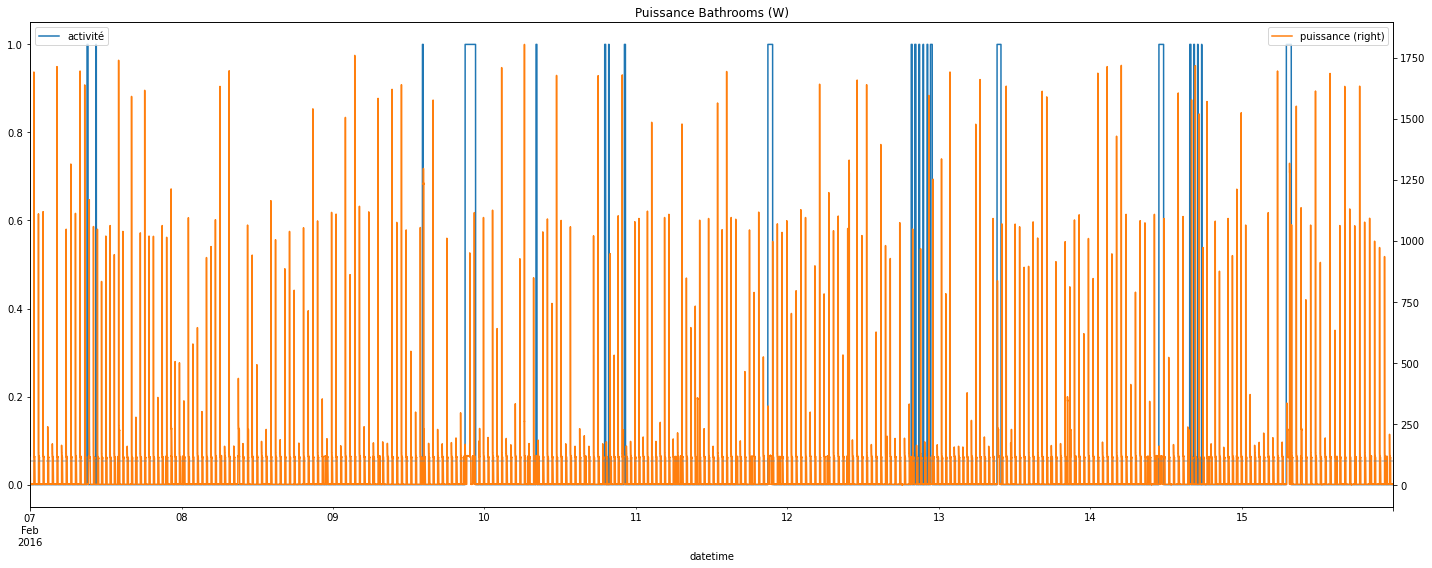

In [12]:
fig, ax = plt.subplots(1,1 , figsize=(20,8))

house1_power_blk1_resample = house1_power_blk1[groups_subs13_24] #.resample(rule='0.5H').mean().interpolate(method='linear')
tol = house1_power_blk1[groups_subs13_24].mean() + house1_power_blk1[groups_subs13_24].std() * 1.1

col = groups_subs13_24[4]

((((house1_power_blk1[col] > tol[col])*1).rolling('45min', center=True).mean() > 0.4)*1).plot(label='activité', ax=ax);
axr = house1_power_blk1_resample[col].plot(title=f'Puissance {col} (W)',secondary_y=True, label='puissance', ax=ax);
axr.axhline(y=tol[col], linestyle='dashed', color='gray', alpha=0.5);

ax.legend(loc='upper left');
axr.legend(loc='upper right');

fig.tight_layout();

Il semble y avoir un équipement branché en permanence (VMC?). Ce compteur ne semble pas adapté à la detection d'activité.

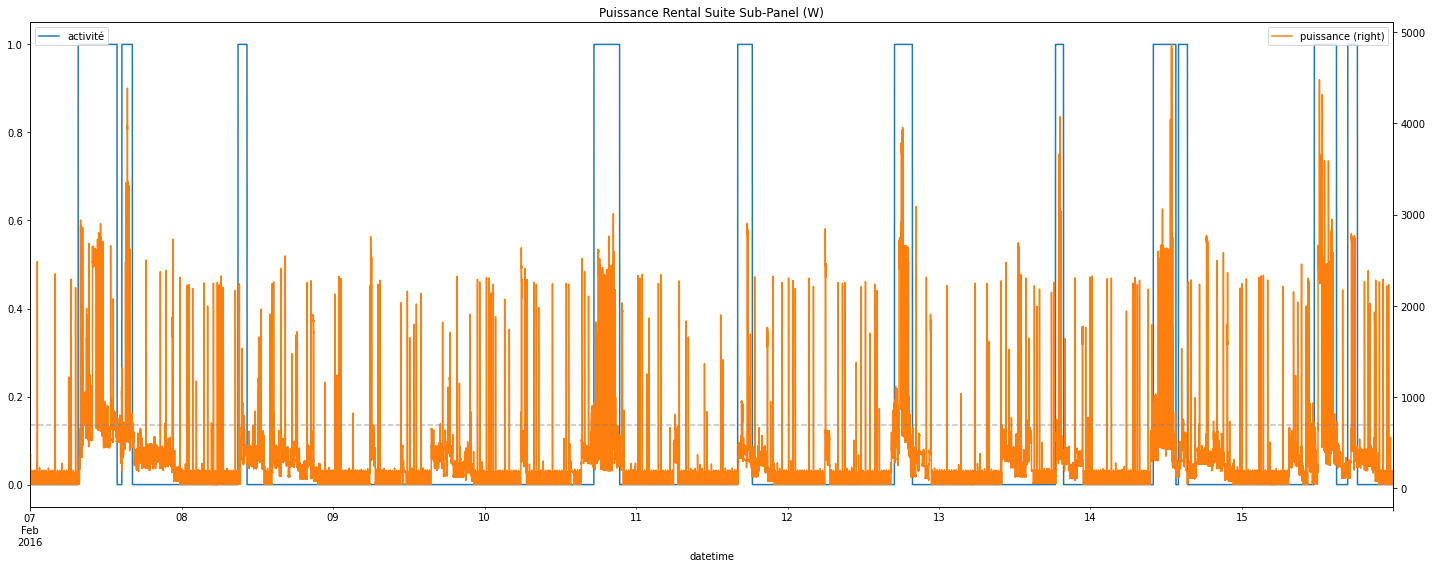

In [13]:
fig, ax = plt.subplots(1,1 , figsize=(20,8))

house1_power_blk1_resample = house1_power_blk1[groups_subs13_24] #.resample(rule='0.25H').mean().interpolate(method='linear')
tol = house1_power_blk1[groups_subs13_24].mean() + house1_power_blk1[groups_subs13_24].std() * 0.8

col = groups_subs13_24[5]

((((house1_power_blk1[col] > tol[col])*1).rolling('1h30min', center=True).mean() > 0.1)*1).plot(label='activité', ax=ax);
axr = house1_power_blk1_resample[col].plot(title=f'Puissance {col} (W)',secondary_y=True, label='puissance', ax=ax);
axr.axhline(y=tol[col], linestyle='dashed', color='gray', alpha=0.5);

ax.legend(loc='upper left');
axr.legend(loc='upper right');

fig.tight_layout();

Ce signal est également très bruité et difficilement exploitable.

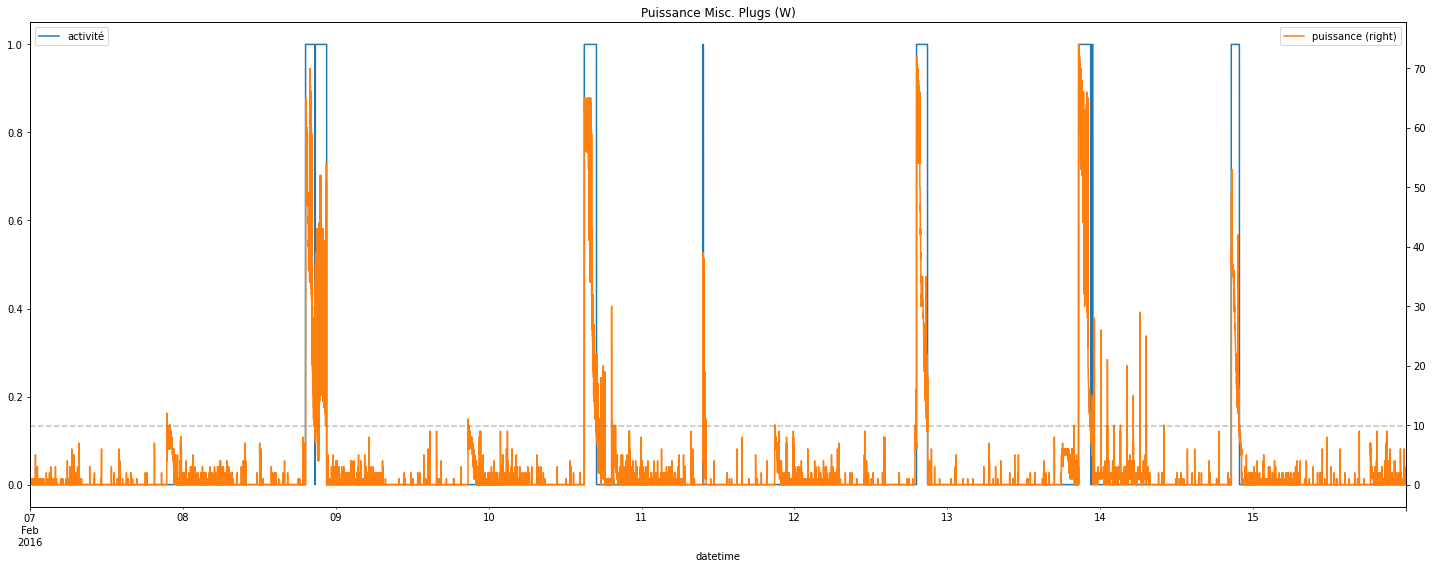

In [14]:
fig, ax = plt.subplots(1,1 , figsize=(20,8))

house1_power_blk1_resample = house1_power_blk1[groups_subs13_24] #.resample(rule='0.25H').mean().interpolate(method='linear')
tol = house1_power_blk1[groups_subs13_24].mean() + house1_power_blk1[groups_subs13_24].std()

col = groups_subs13_24[6]

((((house1_power_blk1[col] > tol[col])*1).rolling('5min', center=True).mean() > 0.15)*1).plot(label='activité', ax=ax);
axr = house1_power_blk1_resample[col].plot(title=f'Puissance {col} (W)',secondary_y=True, label='puissance', ax=ax);
axr.axhline(y=tol[col], linestyle='dashed', color='gray', alpha=0.5);

ax.legend(loc='upper left');
axr.legend(loc='upper right');

fig.tight_layout();

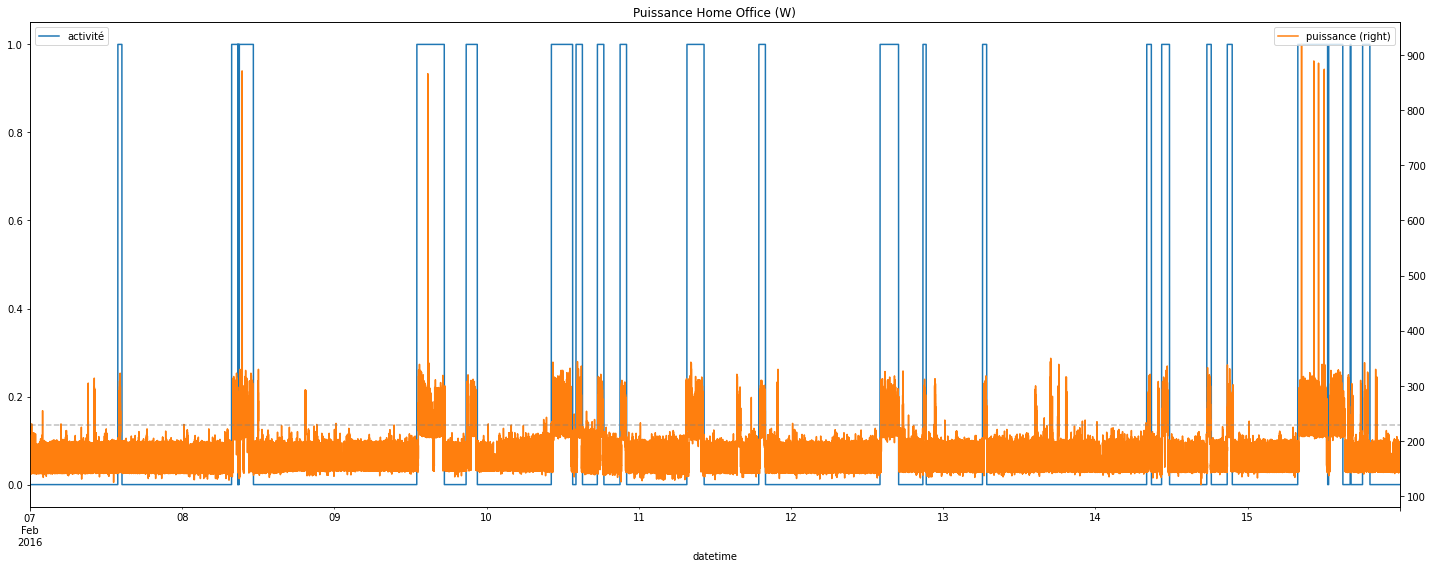

In [15]:
fig, ax = plt.subplots(1,1 , figsize=(20,8))

house1_power_blk1_resample = house1_power_blk1[groups_subs13_24] #.resample(rule='0.25H').mean().interpolate(method='linear')
tol = house1_power_blk1[groups_subs13_24].mean() + house1_power_blk1[groups_subs13_24].std() * 2

col = groups_subs13_24[7]

((((house1_power_blk1[col] > tol[col])*1).rolling('45min', center=True).mean() > 0.1)*1).plot(label='activité', ax=ax);
axr = house1_power_blk1_resample[col].plot(title=f'Puissance {col} (W)',secondary_y=True, label='puissance', ax=ax);
axr.axhline(y=tol[col], linestyle='dashed', color='gray', alpha=0.5);

ax.legend(loc='upper left');
axr.legend(loc='upper right');

fig.tight_layout();

Agrégation des résulats : nous allons agréger tous les résultats et tracer le graphe de l'activité vs la courbe de charge sur les appaeils correspondants à de l'activité.

In [6]:
params =pd.DataFrame (data={'tol1mul': [1, 1, 0.1, 1, 1.1, 0.8, 1,2],
                            'rolling': ['2h', '15s', '45min', '10min', '45min', '1h30min', '5min', '45min'],
                            'tol2': [0.11, 0, 0, 0.2, 0.4, 0.1, 0.15 , 0.1]})

In [33]:
activity = pd.Series(data=np.zeros(777600), index=house1_power_blk1.index, dtype=np.int8)

for i, group in enumerate(groups_subs13_24):
    if not h1_labels.loc[h1_labels['group'] == groups_subs13_24[i], 'activity'].any():
        continue

    activity += ((((house1_power_blk1[group] > house1_power_blk1[group].mean() + house1_power_blk1[group].std() * params.loc[i, 'tol1mul'])*1).rolling(params.loc[i, 'rolling'], center=True).mean() > params.loc[i, 'tol2'])*1)

    activity = (activity > 0)*1

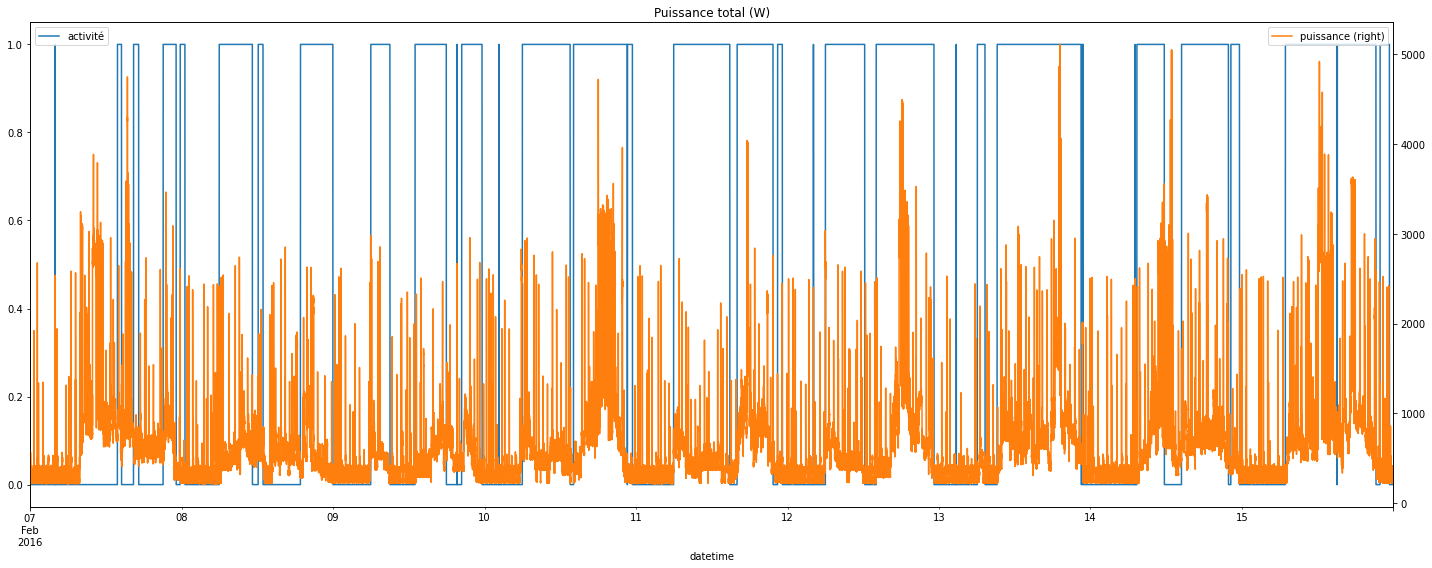

In [34]:
fig, ax = plt.subplots(1,1 , figsize=(20,8))

activity.plot(label='activité', ax=ax);
axr = house1_power_blk1[list(set(labels_active) & set(groups_subs13_24))].sum(axis=1).plot(title=f'Puissance total (W)',secondary_y=True, label='puissance', ax=ax);

ax.legend(loc='upper left');
axr.legend(loc='upper right');

fig.tight_layout();

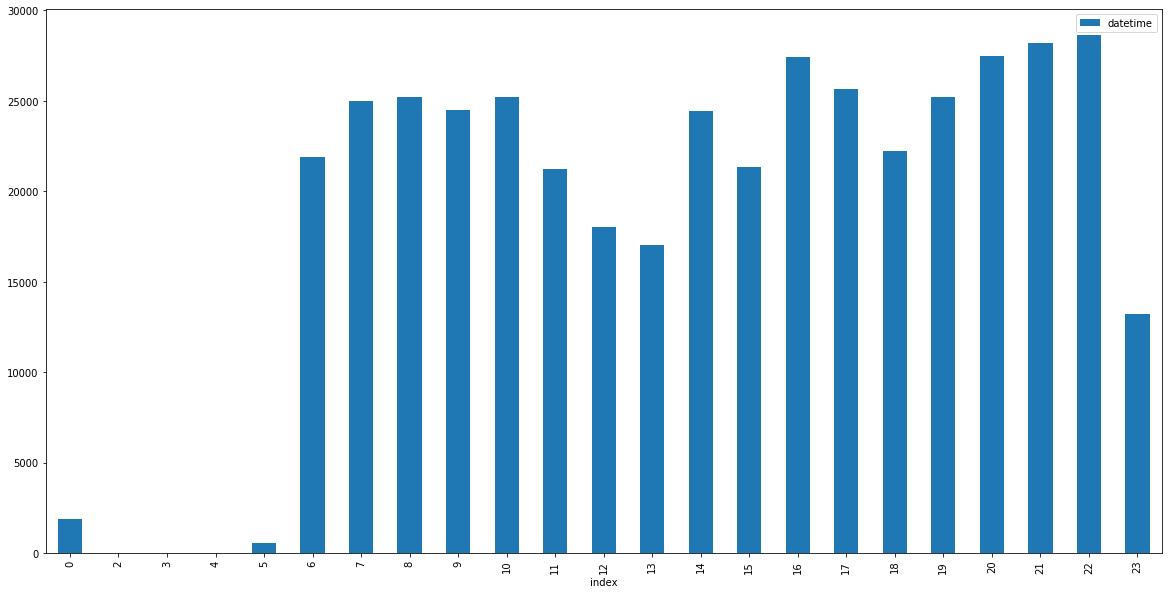

In [35]:
pd.DataFrame(house1_power_blk1[activity > 0].index.hour.value_counts()).reset_index(drop=False).sort_values(by='index').plot.bar(x='index', y='datetime', figsize=(20,10), legend='Histogramme activité=f(heure)');
